# Business Idea: Real-Time Client Satisfaction Detection System for Service Industries

Overview: 
Develop a "Real-Time Client Satisfaction Detection System" specifically designed for service industries such as hospitality, banking, healthcare, and customer support centers. This system utilizes face emotion detection technology to gauge client satisfaction in real time, providing immediate feedback to service providers to enhance the client experience dynamically.

Problem statement:
Not know user satisfaction for a particular service or product.

Why is it important:
This provides real time feedback of user opinion.

How solving this problem will benefit the company:
By logging user emotions when accessing let's say a certain screen in an app, we can have an idea if this screen is user friendly for example if the user seems to give positive emotions or it is bad and needs to be fixed if user face emotions are negarive. This provides a faster way of feedback that the user does not need to do anything about other than give consent to be read in certain places in the software.

Another business idea would be to replace emojis with face emotions in chatting apps, for example send someone your mood which is read by this model instead of an emoji. I have implemented a similar idea about 4 years ago in this project (https://retrochat97.netlify.app/) 

How would you collect relevant data:
Data was taken from kaggle (https://www.kaggle.com/datasets/msambare/fer2013)

How would you formulate this problem as a machine learning task:
The data from the source above comes in two folders, training and testing, each containing sub folders which are named after the emotion of the images inside them, angry, happy, sad, neutral, disgust, fear, and surprise. The idea i had to manage this is by combining both folders into one folder containing the sub foders of emotions with the 48x48 grey scale images inside, then read them with a loop and flatten them into grey scale in a dataframe with the assigned class for each row, now i have a dataframe which i can proceed the usual with.

In [55]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [57]:
emotion_to_number = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "sad": 4,
    "surprise": 5,
    "neutral": 6
}
folder = "./db"
data = []
for label in os.listdir(folder):
    label_folder = os.path.join(folder, label)
    if os.path.isdir(label_folder): 
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = Image.open(img_path).convert('L') 
            img = img.resize((48, 48))
            img = np.array(img)
            img = img.flatten()
            data.append(np.append(img, emotion_to_number[label.lower()])) 
# shuffle to get them mixed up for fair split 
data = shuffle(data, random_state=42)

## Data exploration:

The dataframe is made from a folder contianing sub folders with images inside them so i already know there are no missing values.

Good to show that the data shape is 35887 records with 2304 columns which is exactly 48x48, a flattened grey scale image.

In [58]:
df = pd.DataFrame(data, columns=[*range(2304), "emotion"])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,emotion
0,253,254,255,253,255,245,208,172,169,151,...,253,254,255,255,254,255,255,253,255,2
1,196,223,136,163,127,140,128,106,96,102,...,219,205,200,197,196,191,190,162,156,3
2,233,216,179,157,144,145,155,171,183,177,...,222,221,221,221,221,221,221,221,221,2
3,6,6,9,9,83,114,35,18,28,20,...,153,78,17,8,9,9,11,6,8,4
4,185,50,3,19,9,9,7,12,26,8,...,111,204,224,226,225,225,224,225,226,3


In [61]:
x = df.drop(['emotion'], axis=1)
y = df['emotion']
x.shape

(35887, 2304)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28709, 2304) (7178, 2304) (28709,) (7178,)


## Data preprocessing and feature engineering

Scaling the training data with StandardScaler to avoid ranking them based on grey scale values which is not desirable

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(X_train_scaled)

(28709, 2304)
(7178, 2304)
[[ 0.13290277  0.43354239  0.42639928 ...  0.0037627   0.08315867
   0.1848582 ]
 [ 1.43233363  0.19849304 -0.11400979 ... -1.17533395 -1.26578681
  -1.22774702]
 [ 1.62664105  1.67064426  1.46951447 ...  1.83071466  1.81751714
   1.76290368]
 ...
 [-0.58360584 -1.00149578 -0.98117783 ...  1.84367176  1.81751714
   1.77562985]
 [ 0.74011345  0.79230193  0.84113183 ... -0.09989415 -0.58489052
  -0.97322356]
 [-1.44584501 -1.44685245 -1.42104568 ... -0.38495048 -0.54634922
  -1.07503294]]


Implementing PCA to reduce the number of features from 2304 to 274, retaining 95% of the original data.

In [65]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(X_train_pca.shape)
print(X_test_pca.shape)

(28709, 274)
(7178, 274)


After trying different models, SVM with rbf kernel turned out to give the best accuracy here so it has been used

In [66]:
svc_rbf_model = SVC(kernel='rbf', max_iter=100000, C=2)
svc_rbf_model.fit(X_train_pca, y_train)

SVC(C=2, max_iter=100000)

In [67]:
prediction = svc_rbf_model.predict(X_test_pca)

In [68]:
accuracy = accuracy_score(y_test, prediction)
accuracy

0.4743661186960156

## model assessment step

The model is not ideal for this task but since this is what we have taken in this semster, so be it for the time being.

Exporting the model, scaler, and pca to joblib to be used in front end

In [69]:
from joblib import dump
dump(svc_rbf_model, 'model.joblib')
dump(pca, 'pca.joblib')
dump(scaler, 'scaler.joblib')

['scaler.joblib']

# Using the model in a real environment:

By integrating the joblib model to a next js project using react, can be found in this repo (https://github.com/AtheerAPeter/face-emotions-recognition-svm)

The implementation is made using Next js,
after cloning the repo, node modules need to be installed by `npm i` or `yarn` then run `npm run dev` to run it on `http://localhost:3000`
this link shows a camera open with a button (predict) which predicts the emotion of the face shown in the camera view.

it also has a service which can be used in other applications by sending the image as a base64 string to the end point `http://localhost:3000/predict`

**The end point can be hit with**
```
curl --location 'http://localhost:3000/api/predict' \
--header 'Content-Type: application/json' \
--data '{

    "image":"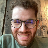"
}'
```

this is a cURL request with a base64 image that shows a happy face the response should be "3"

response:

```
{
    "prediction": "3"
}
```


As expected it returns "3" which means happy 

# How it works


The end point takes the base64 image string, saves it to tmp folder then calls the python script which reads the image from tmp folder, resizes it to 48*48, converts it to grey scale, flattens it, runs it by the scaler and the pca to have a similar looking set of features as the model is trained on, then it runs it by the model, then the prediction is saved in a csv in the tmp folder then its back to the controller in the end point which will read the csv file and sends the result of it as a respoonse to the frontend.